# Lab / M2-DS / AMIR / Phase Vocoder

- Author: geoffroy.peeters@telecom-paris.fr
- Date: 2022/01/17
- Version: 1.1 (switch to English, pythonify code)

# Introduction

The goal of this Lab is to become familiar with audio signal processing in the frequency domain, in particular using the Short Term Fourier Transform (STFT).

The Lab will be carried out in Python.
The aim will be to program cleanly.
This includes 
- The subdivision of the main problem to be solved into sub-problems. Each sub-problem is written as a function/method/class (especially when these functions/methods are to be used more than once),
- the use of variable names and function/method names that clearly indicate their content or functionality,
- the documentation of the written code.

The goal of this Lab is to perform the complete processing chain: STFT + denoising + phase-vocoder (time stretching without changing the frequency) + inverse STFT.

Audio (.wav) signals can be read from files using ```scipy.io.wavfile.read```.
The resulting denoised time-stretched audio signal will be written in a file using ```scipy.io.wavfile.write```.

In case the audio signal is stereo (2 channels), we will use the mean value over the two channels using the function ```np.mean```.

## Your task:

In the following the main code (global architecture) is provided.
Your task is to fill in the missing parts in the code; i.e. the parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```).


# Load packages, parameters and define generic functions

In [3]:
import numpy as np
import scipy.io.wavfile
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

import sys
import IPython.display as ipd

import ipdb


audio_file = './speech_noise.wav'
do_student = True

In [4]:
def nextpow2(i):
    """
    Find 2^n that is equal to or greater than.
    """
    n = 1
    while n < i:
        n *= 2
    return n

In [5]:
def F_plot1(x_v, y_v, labelX, labelY):
    """
    """
    plt.figure(figsize=(12,6));

    plt.plot(x_v, y_v);
    plt.xlabel(labelX); plt.ylabel(labelY)
    plt.grid(True)
    return

In [6]:
def F_plot2(data_m, col_v=np.zeros(0), row_v=np.zeros(0), labelCol='', labelRow=''):
    """
    """
    plt.figure(figsize=(12,6));

    if len(col_v) == 0:
        col_v = np.arange(0, data_m.shape[0])
    if len(row_v) == 0:
        row_v = np.arange(0, data_m.shape[1])

    plt.imshow(data_m, origin='lower', aspect='auto', extent=[row_v[0], row_v[-1], col_v[0], col_v[-1]], interpolation='nearest')
    plt.colorbar()
    plt.set_cmap('gray_r')
    plt.xlabel(labelRow); plt.ylabel(labelCol)
    plt.grid(True)
    return

In [7]:
def F_to_log(X_m):
    """
    apply log and clip at threshold a spectral representation
    """
    logX_m = np.log(X_m)
    T = np.max(logX_m)-10
    logX_m[logX_m<T]=T
    return logX_m

# First step: compute STFT from audio and compute audio from STFT

Since all of the following processings are based on the STFT analysis and audio re-synthesis is performed using inverse STFT, we will start by implementing these two features
- ```C_stft```: a class that calculates the STFT from the audio signal. Writting a class (and not a function) will allow us to store all necessary information for further processings.
- ```F_inverse_stft```: a function that computes the audio signal from its complex STFT (stored as a matrix containing the complex spectra at each analysis time)à using overlap-add algorithm (inverse STFT).

We ask you to write the code to compute the STFT, i.e. to write the code that will perform a loop over frame, windowing the audio signal, compute the DFT and store it in a matrix.
You should **not** use a function with a pre-build STFT (such as ```scipy.signal.stft```).
Writting the code yourself will actually help you being familiar with the process and allows you to write easely the inverse stft code.

You will use 
- a hanning window of length ```L_sec=60``` ms
    - Question: How do you calculate the size of the window in samples ```L_n```?
- a hop size (distance between two successive frames) ```STEP_sec``` equal to 1/3 of the window length: ```STEP_sec=20```ms
- a number of DFT points ```N``` equal to **four time** the first power of 2 greater than ```L_n```
    - you will use the function ``nextpow2``.

Question: How do you calculate the size of the window in samples ```L_n```? 

```L_n=L_{sec}*self.sr_hz```

## Get STFT from the audio signal

Class to be written ```C_stft```

**Allocation**
- Compute the number of frames ```nb_frame``` that is necessary to represent the signal length
    - This number depends on the length of the audio signal in samples ```LT_n```, of the window size in samples ```L_n``` and of the hop size in samples ```STEP_n```.
        - Question: What is this formula?
- Allocate the ``X_im`` matrix of size ```(N/2+1, nb_frame)``` into which the complex spectrum vectors will be stored at each frame
    - Note: only the positive half-axis of the DFT (from 0 to ```N/2```) will be stored
        - All processing will be done on the positive half-axis

**Loop**
- Create a loop from 0 to ```nb_frame-1``` advancing over time by ```STEP_n``` samples
    - take an audio signal of duration equal to ```L_n```
    - multiply it the analysis window
    - calculate its DFT of size ```N``` using the function ```np.fft.rfft```
    - we keep only the positive half-axis of the DFT (this is what returns ```np.fft.rfft```)
    - we store it in a matrix ```X_im``` of size ```(N/2+1, nbFrame)```

The formula for nb_frame is : 
```nb_frame = 1 + int((LT_n - L_n) / STEP_n)```

In [8]:
class C_stft:
    """
    audio_v:    contains the audio signal
    sr_hz:      sampling rate in Hz of the audio signal
    L_sec:      analysis window length in seconds
    STEP_sec:   analysis step in seconds
    L_n:        analysis window length in samples
    STEP_n:     analysis step in samples
    LT_n:       total length of audio signal in samples
    N:          size of the DFT
    window_v:  contains the values of the analysis window
    axis_freq_hz_v: frequency axis of half of the FFT in Hz (only used for plots)
    axis_time_sec_v: time axis storing the position (in second) of the analysis window over the input signal
    """

    audio_v = []
    sr_hz = []
    L_sec = 0.06
    STEP_sec = 0.06/3
    L_n = []
    STEP_n = []
    LT_n = []
    N = []
    window_v = []
    axis_freq_hz_v = []
    axis_time_sec_v = []


    def __init__(self, audio_file):
        
        self.sr_hz, self.audio_v = scipy.io.wavfile.read(audio_file) 
        self.audio_v = np.mean(self.audio_v, axis=1) / 2**16
        self.L_sec = 0.06
        self.STEP_sec = 0.06/3
        
    def __setattr__(self, attrName, val):
        if hasattr(self, attrName):
            self.__dict__[attrName] = val
        else:
            raise Exception("self.%s note part of the fields" % attrName)

    def get_stft(self):
        """
        description:
            compute the complex short-time-fourier-transform
        outputs:
            - X_im (N/2+1, nb_frame): complex numpy matrix which stores the complex STFT 
                (because of symetry we only keep the positive axis, hence N/2+1)
        """

        if do_student:
            # --- START CODE HERE
            self.L_n = int(self.L_sec * self.sr_hz)
            self.window_v = np.hanning(self.L_n)
            self.STEP_n = int(self.STEP_sec * self.sr_hz)
            self.N = 4 * nextpow2(self.L_n)
            self.LT_n = len(self.audio_v)
            
            nb_frame = 1 + int((len(self.audio_v) - self.L_n) / self.STEP_n)
            self.axis_freq_hz_v  = np.linspace(0,self.sr_hz/2,self.N//2 +1)
            self.axis_time_sec_v = np.linspace(0,nb_frame*self.STEP_n/self.sr_hz)
            X_im = np.zeros((self.N//2 +1, nb_frame), dtype='complex')
            
            for num_frame in range(nb_frame):
                x_frame = self.audio_v[num_frame * self.STEP_n : self.L_n + num_frame * self.STEP_n] * self.window_v
                # Take the DFT (non-negative frequencies only)
                fft = np.fft.rfft(x_frame, n =self.N)
                X_im[:,num_frame] = fft
                
            # --- END CODE HERE
        return X_im

### Test

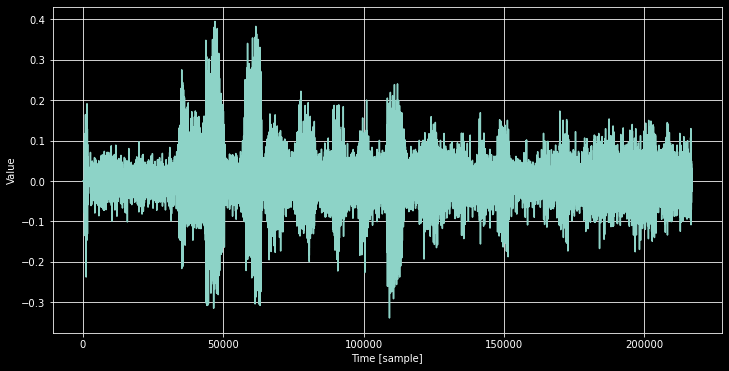

In [9]:
my_stft = C_stft(audio_file)
# +++++++++++++++++++++++++
F_plot1(np.arange(0, my_stft.audio_v.shape[0]), my_stft.audio_v, 'Time [sample]', 'Value')
ipd.Audio(my_stft.audio_v, rate=my_stft.sr_hz)

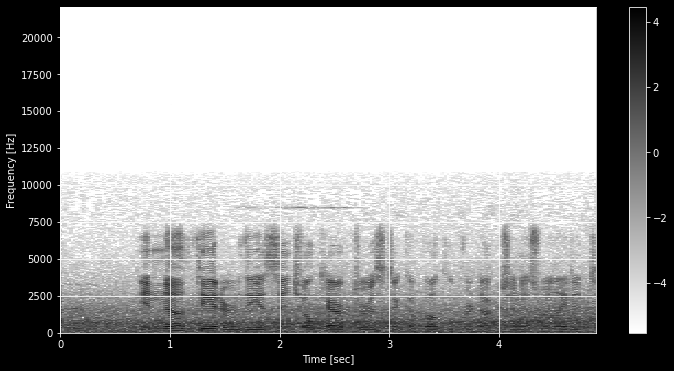

In [10]:
X_im = my_stft.get_stft()

# +++++++++++++++++++++++++
F_plot2(F_to_log(np.abs(X_im)), my_stft.axis_freq_hz_v, my_stft.axis_time_sec_v, 'Frequency [Hz]', 'Time [sec]')

## Re-create audio signal from STFT using overlap-add method

Function to write: ```F_inverse_stft```

**Allocation**
- Allocate the time vector ```hat_audio_v``` in which the progressive addition/overlapping of the audio frames will be stored
- Allocate the time vector ```hat_window_v``` in which the progressive addition/overlap of the analysis window will be stored

**Loop**
- We create a loop through the columns (the frames) of the matrix ```X_im```.
    - For each column we calculate its inverse DFT and keep its real part (```real(ifft())```)
    - Truncate the resulting signal to length ```L_n```.
    - Perform the overlap/add operation of the audio signal
        - At which position should the signal be added?
        - ```Answer : A signal of length L_n should be added each STEP_n.```
    - Perform the overlap/add operation of the analysis window

**Normalisation**
- Once the whole audio signal is obtained by addition/overlap, it is normalized by the overlapped/added analysis windows
    - We will avoid division by 0 by adding the a very small value.

In [29]:
def F_inverse_stft2(my_stft, X_im):
    """
    inputs:
        my_stft: object from class C_stft
        X_im: complex STFT of size (N/2+1, nb_frame)
    outputs:
        hat_audio_v: audio signal re-created using inverse STFT (overlap-add method)
    """
    
    if do_student:
        # --- START CODE HERE
        window_v = np.hanning(my_stft.L_n)
        nb_frame = X_im.shape[1]
        #hat_audio_v = np.zeros(my_stft.LT_n)
        #hat_window_v = np.zeros(my_stft.LT_n)
        hat_audio_v = np.zeros(nb_frame*(my_stft.STEP_n-1) + my_stft.L_n)
        hat_window_v = np.zeros(nb_frame*(my_stft.STEP_n-1) + my_stft.L_n)
        for num_frame in range(nb_frame):
            hat_signal_v = np.real(np.fft.irfft(X_im[:,num_frame], n = my_stft.N))
            # --- get position where to overlap and add
            hat_audio_v[num_frame * my_stft.STEP_n:num_frame * my_stft.STEP_n + my_stft.L_n] += hat_signal_v[:my_stft.L_n] #* my_stft.window_v[:my_stft.L_n]
            hat_window_v[num_frame * my_stft.STEP_n:num_frame * my_stft.STEP_n + my_stft.L_n] += my_stft.window_v[:my_stft.L_n]#**2
        
        # --- normalisation
        hat_window_v[hat_window_v==0] = 1e-1
        hat_audio_v = hat_audio_v / hat_window_v
        # --- END CODE HERE
    return hat_audio_v

In [30]:
def F_inverse_stft(my_stft, X_im):
    """
    inputs:
        my_stft: object from class C_stft
        X_im: complex STFT of size (N/2+1, nb_frame)
    outputs:
        hat_audio_v: audio signal re-created using inverse STFT (overlap-add method)
    """
    
    if do_student:
        # --- START CODE HERE
        window_v = np.hanning(my_stft.L_n)
        nb_frame = X_im.shape[1]
        hat_audio_v = np.zeros(my_stft.LT_n)
        hat_window_v = np.zeros(my_stft.LT_n)
    
        n=(my_stft.LT_n-my_stft.L_n)/my_stft.STEP_n
        for num_frame,k in enumerate(np.linspace(0,nb_frame-1,int(n)+1).astype(int)):
            hat_signal_v = np.real(np.fft.irfft(X_im[:,k], n = my_stft.N))
            # --- get position where to overlap and add
            hat_audio_v[num_frame * my_stft.STEP_n:num_frame * my_stft.STEP_n + my_stft.L_n] += hat_signal_v[:my_stft.L_n] #* my_stft.window_v[:my_stft.L_n]
            hat_window_v[num_frame * my_stft.STEP_n:num_frame * my_stft.STEP_n + my_stft.L_n] += my_stft.window_v[:my_stft.L_n]#**2
           
        # --- normalisation
        hat_window_v[hat_window_v==0] = 1e-5
        hat_audio_v = hat_audio_v / hat_window_v
        # --- END CODE HERE
    return hat_audio_v

### Test

We will check that the whole chain: audio -> STFT ```X_im``` -> inverse STFT.
The output should give exactly the same audio signal as the input

This can be done by superimposing the two waveforms:
``plot(my_stft.audio_v), plot(hat_audio_v, 'r--')``.
They should overlap perfectly.

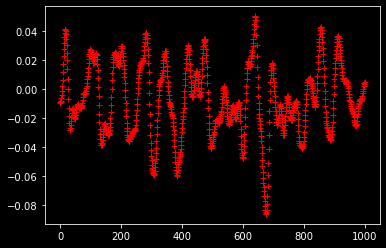

In [31]:
hat_audio_v = F_inverse_stft(my_stft, X_im)

# +++++++++++++++++++++++++
s = 5000
e = s + 1000
plt.plot(my_stft.audio_v[s:e], 'k-')
plt.plot(hat_audio_v[s:e], 'r+')

ipd.Audio(hat_audio_v.squeeze(), rate=my_stft.sr_hz)

# Second step: denoising the signal using spectral subtraction

Function to write: ```F_denoising_spectral_subtraction.m```

The audio signal ```speech_noise.wav``` contains a voice signal over crowd noise in a stadium.
We want to denoise this signal by removing the crowd noise.
The spectral subtraction algorithm will be used for this.
The complex spectrogram ``X_im`` already calculated will be used for this.

- The noise (crowd signal in a stadium) is present in an isolated way between the times 0.1 and 0.7~s.
    - Question: how to find the interval of the corresponding $T$ frames of ```|X_im|``` ?
    - ```Answer :  we need to convert the time in step. For that we multiply by the sampling rate. So we keep the signal between int(my_stft.sr_hz * start_sec) and  int(my_stft.sr_hz * stop_sec)```
- We will use this interval $T$ of ```|X_im|``` to calculate the noise footprint to be removed: $\mu(\omega) = \mathbb{E}_{\tau \in T} \{ |N(\omega,\tau)| \}$
- We will then calculate at each frame $\tau$ the filter $H(\omega,\tau) = 1-\frac{\mu(\omega)}{|X(\omega,\tau)|}$
    - Note: one can greatly accelerate the calculation by using the matrix computation, in particular the division term-by-term or the multiplication term-by-term.
- To avoid the negative values of the filter $H$, we will apply to each frame $\tau$ a Half-Wave-Rectification (HWR) on $H$: $H_R(\omega,\tau) = \frac{H(\omega,\tau) + |H(\omega,\tau)|}{2}$


- The complex spectrogram ``hat_X_im`` is reconstructed by simple matrix term-by-term multiplication: ```hat_X_im = H_m .* X_im ```

- The corresponding audio signal will be reconstructed with the inverse STFT algorithm developed earlier: ``F_inverse_stft``.

In [12]:
def F_denoising_spectral_subtraction(my_stft, X_im, start_sec, stop_sec):
    """
    inputs:
        my_stft: object from class C_stft
        X_im: complex STFT of size (N/2+1, nb_frame)
        start_sec, stop_sec: location over time (in second) where the noise should be captured
    outputs:
        hat_X_im: denoised complex STFT of size (N/2+1, nb_frame)
    """
    
    
    if do_student:
        # --- START CODE HERE
        N = my_stft.audio_v[int(my_stft.sr_hz * start_sec): int(my_stft.sr_hz * stop_sec)]
        mu_v = np.mean(np.absolute(N))
        H_m = 1 - mu_v / (np.abs(X_im)+1e-5)
        HR_m = (H_m + np.absolute(H_m))/2
        hat_X_im = H_m * X_im
        # --- END CODE HERE
 
    return hat_X_im

### Test

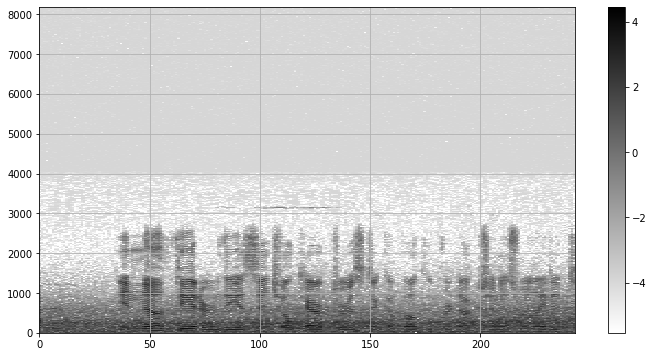

In [13]:
denoised_X_im = F_denoising_spectral_subtraction(my_stft, X_im, 0.1, 0.7)
denoised_audio_v = F_inverse_stft(my_stft, denoised_X_im).ravel()


# +++++++++++++++++++++++++
F_plot2(F_to_log(np.abs(denoised_X_im)))
ipd.Audio(denoised_audio_v, rate=my_stft.sr_hz)

# Third step: time-stretching using phase-vocoder

Function to write: ```F_phase_vocoder```

The phase vocoder algorithm will be used to slow down the raw signal by a value of ```alpha=0.6```.

**Allocation**
- If we note ```R_ana``` the number of analysis frames, we calculate the number of synthesis frames ```R_syn = round(R_ana/alpha)``` required for the requested ```alpha``` expansion
- We then allocate the matrix that will contain, at each synthesis frame $r_syn$, the modified complex spectra ```hat_X_im```. It is of dimension ``(N/2+1, R_syn)``.

**Loop**
- We will then create a loop over the synthesis frames $r_{syn} \in [0,R_{syn}[$.
    - For a given synthesis frame ```r_syn```, the corresponding analysis frame will be calculated according to the rule of three: ```r_ana = r_syn*(R_ana-1)/(R_syn-1)```.
    

## Amplitude computation

- The amplitude spectrum ```am_fft_v``` is computed as the interpolation between the analysis data at frame ```r1=floor(r_ana)``` and ```r2=r1+1```.


## Phase computation

There are three possibilities to compute the phase. Only the third one is correct, but we ask you to implement the three of them.

In the three cases,
- We get the complex spectrum at frame ``r_syn`` using the interpolated amplitude spectrum and the specific phase spectrum
    - ```hat_X_im(:,r_syn) = am_fft_v .* exp(j * cumul_phase_v)```
- The corresponding audio signal will be reconstructed using the inverse STFT algorithm applied to ```hat_X_im```

### Solution 1 (wrong): phase spectrum equal zero

- At each synthesis frame, we use a phase spectrum equal to zero ```cumul_phase_v=0```
- Note: listening to the obtained signal we can hear a robotic signal
- Question: How can we change the pitch of the robot ?
    - Advanced: Try running the program again by changing the step size of the STFT ``STEP_sec``.


### Solution 2 (wrong): phase spectrum is incremented using the theoretical frequencies

- At each synthesis frame, we increment the phase spectrum ```cumul_phase_v``` using the theoretical value corresponding to each frequency $f_k$ of the spectrum.
- As a reminder, for a STFT bin at frequency $f_k$, the theoretical model consider that the phase evolves over time as $\Delta \Phi = 2 \pi f_k \Delta t$, where $\Delta t$ corresponds here to the hop size ```STEP_n```.
    - Question: how do we calculate the frequencies $f_k$ in Hz of the DFT ?
    - Question: how do we calculate $\Delta t$ from ```STEP_n```
- The phases will be incremented progressively during the synthesis frames. This is to ensure continuity in the evolution of the phase for each frequency
    - ```cumul_phase_v += delta_phi_v```
    - The initial synthesis phase (for ```r_syn=0```) is chosen to be that of the initial complex analysis spectrum (in ```r=0```)
- Remark: when listening to the signal ``ipd.Audio(hat_audio_v, rate=my_stft.sr_hz)`` we hear a time-modulated signal
- Question: What is the reason for this?

				

### Solution 3 (correct): phase spectrum is incremented using the instantaneous frequencies

- As we saw during the lecture, within the filter $f_k$ of the STFT we can actually observe a signal at a frequency which is different than (but close to) $f_k$. 
- To get this frequency, we need compute the instantaneous frequency $f_0$ using the phases evolution between r1 and r2 observed within the filter $f_k$.
- To resolve the indeterminacy of $n$ (phase wrapping, see lecture), we will look for the instantaneous frequency $f_0$ which is the closest to $f_k$ using
- This leads to
```
		n_v = round( (phi2_v - (phi1_v + delta_phi_v)) / (2*pi))
```
- Question: explain how this is equivalent to finding the closest instantaneous frequency $f_0$ to $f_k$?

In [14]:
def F_phase_vocoder(my_stft, X_im, alpha, do_method = 3):
    """
    inputs:
        - my_stft: object from class C_stft
        - X_im: complex STFT of size (N/2+1, nb_frame)
        - alpha: times-stretching factor (alpha<1 slow-down, alpha>1 speed-up)
        - do_method: {1, 2, 3} defines the algorithm used to compute the synthesis phase spectrum
    outputs:
        - hat_X_im: modified complex STFT of size (N/2+1, new_nb_frame)
    """
    
    
    if do_student:
        # --- START CODE HERE
        R_ana = X_im.shape[1]
        R_syn = int(R_ana/alpha)
        
        hat_X_im = np.zeros((my_stft.N//2+1,R_syn),dtype='complex')
        
        X_im = np.concatenate( (X_im, np.zeros(( X_im.shape[0],1))), axis=1)
        
        cumul_phase_v = np.angle(X_im[:, 0])
        phi_advance = np.linspace(0, np.pi * my_stft.STEP_n, X_im.shape[0])
        
        for r_syn in range(R_syn):
            r_ana = r_syn*(R_ana-1)/(R_syn-1)
            r1 = int(np.floor(r_ana))
            r2 = r1+1
            delta = alpha*r_ana-r1
            
            am_fft_v = (1-delta)* np.absolute(X_im[:,r1]) + delta*np.absolute(X_im[:,r2])
            
            if do_method == 1:
                cumul_phase_v = 0
                hat_X_im[:,r_syn] = am_fft_v * np.exp(1j*cumul_phase_v)
            if do_method == 2:
                delta_ph_v = 2 *np.pi*(my_stft.STEP_n/my_stft.sr_hz) * (0.5*r_syn * my_stft.sr_hz/R_ana)
                cumul_phase_v += delta_ph_v
                hat_X_im[:,r_syn] = am_fft_v * np.exp(1j*cumul_phase_v)
                
            if do_method == 3:
                hat_X_im[:,r_syn] = am_fft_v * np.exp(1.0j * cumul_phase_v)
                # Compute phase advance
                dphase = np.angle(X_im[:, r2]) - np.angle(X_im[:, r1]) - phi_advance
                # Wrap to -pi:pi range
                dphase = dphase - 2.0 * np.pi * np.round(dphase / (2.0 * np.pi))
                # Accumulate phase
                cumul_phase_v += phi_advance + dphase
        # --- END CODE HERE
    return hat_X_im

### Test

In [15]:
stretched_denoised_X_im = F_phase_vocoder(my_stft, denoised_X_im, alpha=0.6, do_method=1)
stretched_denoised_audio_v = F_inverse_stft(my_stft, stretched_denoised_X_im).ravel()
ipd.Audio(stretched_denoised_audio_v[1000:213976], rate=my_stft.sr_hz)

In [16]:
stretched_denoised_X_im = F_phase_vocoder(my_stft, denoised_X_im, alpha=0.6, do_method=2)
stretched_denoised_audio_v = F_inverse_stft(my_stft, stretched_denoised_X_im).ravel()
ipd.Audio(stretched_denoised_audio_v[1000:213976], rate=my_stft.sr_hz)

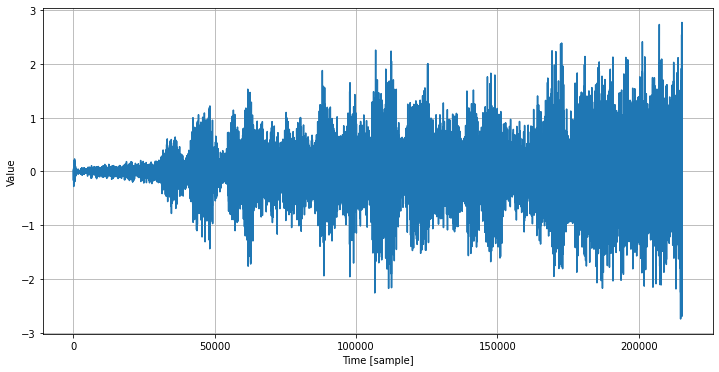

In [17]:
stretched_denoised_X_im = F_phase_vocoder(my_stft, denoised_X_im, alpha=0.6, do_method=3)
stretched_denoised_audio_v = F_inverse_stft(my_stft, stretched_denoised_X_im).ravel()

# +++++++++++++++++++++++++
scipy.io.wavfile.write('./result.wav', my_stft.sr_hz, stretched_denoised_audio_v)
F_plot1(np.arange(0, stretched_denoised_audio_v[1000:216376].shape[0]), stretched_denoised_audio_v[1000:216376], 'Time [sample]', 'Value')
ipd.Audio(stretched_denoised_audio_v[1000:216376], rate=my_stft.sr_hz)